# 2. Adding services to the simulation

Service is a key component to the simulation that defines a running scenario for your experiment.
Each service has access to peer class and Simpy environment. 

At the moment simulation has two abstract service classes: 
1. Runner  
2. Handler


### **Runner**

Runner works as a producer of events, or when you require an action initiative from a peer. For example, a message producer is a runner.

Function to implement: `run()`


### **Handler**

Handler works as a reactive service that handles incoming messages. 

Functions to implement: 
 - `handle_message(msg)` - react upon recieving a message.
 - `@property messages` - list of messages that this service can handle.  


For example, a connection manager is both a runner and a handler as it produces and reacts on messages. 



# Creating new services


The simulation at this point is not very useful. 
Let's create our own service on top of what we have now, i.e. let's build a gossip network.


A gossip protocol ([wiki](https://en.wikipedia.org/wiki/Gossip_protocol)) is an important building block used in almost any P2P system(for example: [hyperledger gossip](https://hyperledger-fabric.readthedocs.io/en/release-1.4/gossip.html), [course slides](http://www.cs.cornell.edu/courses/cs6410/2016fa/slides/19-p2p-gossip.pdf)). 


## Gossip Message Handler

There are multiple ways to implement Gossip: [ttl, anti-entropy etc](http://www.cs.cornell.edu/Projects/Quicksilver/public_pdfs/2007PromiseAndLimitations.pdf).

We will implement one of the simplest versions based on ttl (Time to live), where each message has a predefined $ttl$ parameter. $ttl$ shows a stoping condition for the peer, i.e. if $ttl$=0, the peer should stop, otherwise $ttl$ must be decremented and the message should be gossiped further.

Let's first implement a handler: a service that reacts on incoming gossip messages: 


In [3]:
# Message gossip
from p2psimpy import *
from p2psimpy.services.base import BaseHandler
from p2psimpy.messages import BaseMessage
from p2psimpy.storage import Storage

from re import split 
from copy import copy

# Define a special message GossipMessage: Message with ttl
class GossipMessage(BaseMessage):

    __slots__ = ('sender', 'data', 'ttl')
    size = 1024
    
    def __init__(self, sender, data, ttl):
        super().__init__(sender, data)
        self.ttl = ttl
        
class GossipService(BaseHandler):
    """
    A simple gossip service to handle the gossip messages and pass them to the neighbors. 
    """

    def __init__(self, peer, fanout=3, exclude_peers: set=None, exclude_types: set=None):
        super().__init__(peer)
        
        self.fanout = fanout
        if exclude_peers is None:
            self.exclude_peers = set() 
        else:
            self.exclude_peers = exclude_peers
        self.exclude_types = exclude_types
        
        self.strg_name = 'msg_time'
        self.peer.add_storage(self.strg_name, Storage())

    def handle_message(self, msg):
        # Store message localy 
        msg_id = msg.data
        # Store the message id received with the current timestamp
        self.peer.store(self.strg_name, msg_id, self.peer.env.now)
        if msg.ttl > 0:
            # Rely message further, modify the message
            exclude_peers = {msg.sender} | self.exclude_peers
            # Use peer gossip - it will sample self.config.fanout and exclude sender
            # If you need to exclude some peers: add it to the set
            self.peer.gossip( GossipMessage(self.peer, msg.data, msg.ttl-1), 
                             self.fanout, except_peers=exclude_peers, except_type=self.exclude_types)

    @property
    def messages(self):
        return GossipMessage,


The Peer object has a gossip function that will send a message to a random sample of `fanout` connected peers.
Peers are included in `except_peers` and `except_type` are excluded from the sampling. 


The service implements a reaction on the messages specified in the `messages` property and reacts as follows: 
- Peer stores the message when it is received and keeps the timestamp when the message was received - `self.peer.env.now`. Note also that to store the message first we need to initilize it via `self.peer.add_storage(storage_name, storage_object)`. 
- If the message ttl is positive, the peer sends the message to the `fanout` number of random connected peers with a function `self.peer.gossip(Msg, fanout)`. You can also exclude some peers from the sampling like excluding the sender of the message (from which you get the message) is a reasonable optimization. 





## Message producer 

Finally, we need to create a service that will first create (produce) the message. 
We will inherit a MessageProducer from a `BaseRunner` class.

MessageProducer will have `msg_rate`, `ttl`, `fanout` and a `timeout_delay`.




In [4]:
from p2psimpy.services.base import BaseRunner

class MessageProducer(BaseRunner):

    def __init__(self, peer, init_timeout=1000, msg_rate=5, init_ttl=3, init_fanout=10):
        '''
        init_timeout: milliseconds to wait before starting the message production. 
        msg_rate: number of messages per second
        init_ttl: ttl to set up for the message 
        init_fanout: to how many peer send the message to
        '''
        super().__init__(peer)

        # calculate tx_interval
        self.init_timeout = init_timeout
        self.init_ttl = init_ttl
        self.init_fanout = init_fanout
        
        self.tx_interval = 1000 / msg_rate
        self.counter = 1 
        
        # Let's add a storage layer to store messages
        self.strg_name = 'msg_time'
        self.peer.add_storage(self.strg_name, Storage())


    def produce_transaction(self):
        # Create a gossip message: message counter, peer_id and gossip it   
        self.peer.gossip(GossipMessage(self.peer,
                                       '_'.join((str(self.counter), str(self.peer.peer_id))), 
                                       self.init_ttl), 
                         self.init_fanout)
        # Locally store the message counter 
        self.peer.store(self.strg_name, str(self.counter), self.peer.env.now)
        self.counter+=1
        

    def run(self):
        # Wait the initial timeout
        yield self.env.timeout(self.init_timeout)
        while True:
            self.produce_transaction()
            yield self.env.timeout(self.tx_interval)

Notice that `yield time_to_wait` is used to simulate time and waiting in a simulation. 

-----

## Preparing an Experiment

In [5]:
# Define locations 
from p2psimpy.config import *
from p2psimpy.consts import *
from p2psimpy.services.connection_manager import BaseConnectionManager
import networkx as nx
from random import choice, sample

import matplotlib.pyplot as plt

# We take the locations from AWS 
class Locations(Config):
    locations = ['Ohio', 'Ireland', 'Tokyo']
    latencies = {
        'Ohio': {'Ohio': Dist('invgamma', (5.54090, 0.333305, 0.987249)),
                 'Ireland': Dist('norm', (73.6995, 1.19583092197097127)),
                 'Tokyo': Dist('norm', (156.00904977375566, 0.09469886668079797))
                },
        'Ireland':{'Ireland': Dist('invgamma', (6.4360455224301525, 0.8312748033308526, 1.086191852963273)),
                   'Tokyo': Dist('norm', (131.0275, 0.25834811785650774))
                  },
        'Tokyo': {'Tokyo':  Dist('invgamma', (11.104508341331055, 0.3371934865734555, 2.0258998705983737))}
    }
    
# Define peer     
class PeerConfig(Config):
    location = Dist('sample', Locations.locations)
    bandwidth_ul = Dist( 'norm', (50*MBit, 10*MBit))
    bandwidth_dl = Dist( 'norm', (50*MBit, 10*MBit))

# Configuration used for our GossipService
class GossipConfig(Config):
    exclude_types={'client',}

# We have not two types of nodes: *peer* and *client*
def prepare_peer_types():
    return { 'peer': PeerType(PeerConfig,   {BaseConnectionManager: None,
                                                GossipService: GossipConfig }),
             'client': PeerType(PeerConfig, (BaseConnectionManager, MessageProducer))}

def prepare_topology(num_peers=25, num_clients=1):    
    # Create network topology
    G = nx.erdos_renyi_graph(num_peers, 0.4)   
    nx.relabel_nodes(G, {k: k+1 for k in G.nodes()} ,copy=False)
    
    # Connect the client node to a random peer
    client_edges = [(i, choice(list(G.nodes()))) for i in range(num_peers+1, num_clients+num_peers+1)]
    G.add_edges_from(client_edges)

    types_map = {k: 'peer' if k < num_peers+1 else 'client' for k in G.nodes()}
    # Assign a peer type to the peers 
    nx.set_node_attributes(G, types_map , 'type')
    return G

def visualize_peer_client_network(G):
    plt.figure(figsize=(10,10))

    # Draw client/ peer network 

    master_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'peer']
    client_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'client']

    pos = nx.kamada_kawai_layout(G)

    nx.draw_networkx_nodes(G, pos, nodelist=master_nodes, \
        node_color='blue', node_shape='o', node_size=500)
    nx.draw_networkx_nodes(G, pos, nodelist=client_nodes,  \
        node_color='green', node_shape='^', node_size=500, label=1)

    nx.draw_networkx_labels(G, pos, labels={k:k for k in master_nodes}, font_color='w')
    nx.draw_networkx_labels(G, pos, labels={k:k for k in client_nodes}, font_color='w')

    nx.draw_networkx_edges(G, pos, edgelist=G.subgraph(master_nodes).edges(), width=1.5)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(nbunch=client_nodes),  style='dotted')


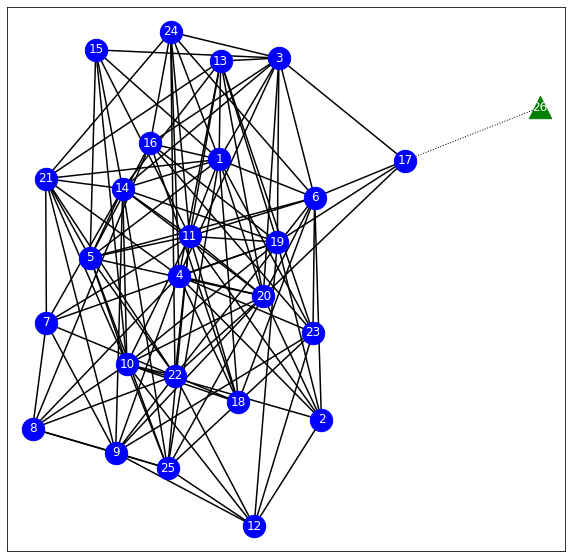

In [6]:
# Prepare and show target network topology 
G = prepare_topology()
visualize_peer_client_network(G)

In [5]:
from time import time
from p2psimpy.simulation import BaseSimulation

net_sim = BaseSimulation(Locations, G, prepare_peer_types())

In [6]:

net_sim.run(5_200)


One of the main properties that we need to achieve with gossip is **convergence**.
**Convergence** is a state where every peer has received the required message. 
The gossip protocols are compared with each other using the **time to convergence** metric.


We can find it by inspecting the time when peer has the received message by looking at `peer.storage`.
For this experiment we used a simple dictionary - *first-seen* storage. 

In [7]:
client_id = 26
print("Time when message was produced by the client: \n", net_sim.peers[client_id].storage['msg_time'].txs)

# Put any peer id you want to inspect
peer_id = 1 

print("Time when the message was received by the peer: \n", net_sim.peers[peer_id].storage['msg_time'].txs)

Time when message was produced by the client: 
 {'1': 1000, '2': 1200.0, '3': 1400.0, '4': 1600.0, '5': 1800.0, '6': 2000.0, '7': 2200.0, '8': 2400.0, '9': 2600.0, '10': 2800.0, '11': 3000.0, '12': 3200.0, '13': 3400.0, '14': 3600.0, '15': 3800.0, '16': 4000.0, '17': 4200.0, '18': 4400.0, '19': 4600.0, '20': 4800.0, '21': 5000.0}
Time when the message was received by the peer: 
 {'2_26': 1202.1165238636938, '3_26': 1531.5245875891244, '4_26': 1732.176266132709, '6_26': 2001.5154044503251, '7_26': 2332.0211497225164, '8_26': 2474.2024072028107, '9_26': 2601.9947810556628, '10_26': 2931.8116381702184, '11_26': 3001.9685829224304, '13_26': 3580.984346807165, '14_26': 3731.4917853753304, '15_26': 3802.0360006419805, '16_26': 4131.514502060715, '17_26': 4331.4354874745195, '18_26': 4532.12301632731, '20_26': 4932.039011159153, '21_26': 5131.539396477815}


In [8]:
# Calculate the delay 

def total_delay(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for k, peer_time in store.items():
        msg_num, client_id = k.split('_')
        client_time = sim.peers[int(client_id)].storage[storage_name].txs[msg_num]
        yield (int(msg_num), peer_time - client_time)
        
dict(total_delay(net_sim, peer_id, 'msg_time'))

{2: 2.1165238636938284,
 3: 131.5245875891244,
 4: 132.1762661327091,
 6: 1.5154044503251498,
 7: 132.02114972251638,
 8: 74.20240720281072,
 9: 1.99478105566277,
 10: 131.81163817021843,
 11: 1.9685829224304143,
 13: 180.9843468071649,
 14: 131.49178537533044,
 15: 2.036000641980536,
 16: 131.51450206071513,
 17: 131.4354874745195,
 18: 132.12301632731032,
 20: 132.03901115915323,
 21: 131.539396477815}

In [9]:
dict(total_delay(net_sim, 6, 'msg_time'))

{1: 0.9701200918344739,
 2: 1.0094779711487263,
 3: 1.0365284894921842,
 4: 1.4792378500510495,
 5: 0.9518914326615686,
 6: 1.0257101032086666,
 7: 132.0656002746423,
 8: 0.9984689976577101,
 10: 131.82348821677851,
 11: 1.0463907321136503,
 12: 1.0482854767474237,
 13: 1.9402066161260336,
 14: 131.95235559593448,
 15: 0.9508218124960877,
 16: 0.9368053923953994,
 17: 2.096368350155899,
 18: 2.0475211997927545,
 19: 181.31587400747048,
 20: 0.9589854539908629,
 21: 1.0381069331160688}

### Exercise

Try to play around with different peer_id values. Try peer that is directly connected to the client, then try peer that is on the edge of the network.

Try the same with an emergent topology.

## Emergent topology creation notes

- To simulate the client node connecting only to one peer as in the random given topology, we limit the maximum number of peers to 2 (bootstrap and 1 peer)
- We change the fanout of the client to 1 to make sure that the gossip message goes to only one peer (continuing with the approach above)
- Sometimes the client node gets too many connections even with the upper limit, so we subclass the P2PConnectionManager class for the client and configure it to ignore new connection efforts if the limit has been reached
- In order to accommodate for the initial bootstrapping process and avoid losing gossip messages, we set the initial timeout of the client to 2000. We also increase the simulation duration by 1000 ms so the gossip messages have the same circulation time as the random given topology.
- We use the default number of min and max peers for the P2PConfig as the first notebook, i.e. 4 and 8 respectively. 



In [10]:
from time import time
from p2psimpy.simulation import BaseSimulation

class ConnectionConfig(Config):
    min_peers = 4
    max_peers = 8

class ClientConnectionConfig(Config):
    min_peers = 1
    max_peers = 2    
    
class MessageProducerConfig(Config):
    init_timeout = 2000
    init_fanout = 1
    
class ClientP2PConnectionManager(P2PConnectionManager):
    
    def recv_hello(self, msg):
        """
        Receive introduction message
        """
        other = msg.sender
        if other not in self.peer.connections and len(self.connected_peers) < self.max_peers:
            self.peer.connect(other)
            self.peer.send(other, Hello(self.peer))
            self.peer.send(other, RequestPeers(self.peer))
            
def prepare_emergent_topology_specs(num_peers=25, num_clients=1): 
    topology_specs = {i:{'type': 'peer'} if i<num_peers+1 else {'type':'client'} for i in range(1, num_peers+num_clients+1)}
    return topology_specs
    
def prepare_emergent_peer_types():
    return {'peer': PeerType(PeerConfig,   {GossipService: GossipConfig,
                                           P2PConnectionManager: ConnectionConfig}),
             'client': PeerType(PeerConfig, {ClientP2PConnectionManager: ClientConnectionConfig,
                                                MessageProducer: MessageProducerConfig })}

In [11]:
em_sim = BaseSimulation(Locations, prepare_emergent_topology_specs(25,1), prepare_emergent_peer_types(),enable_logger=True,logger_dir='logs2')

In [12]:
em_sim.run(6_200)

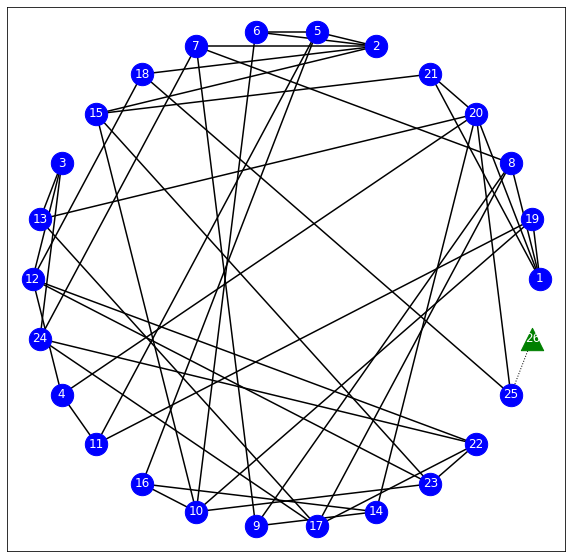

In [13]:
G1 = em_sim.get_graph()

visualize_peer_client_network(G1)

In [14]:
## Client log
with open('logs2/Peer_26:client.log') as s:
    print(s.read())

Peer_26:client WARNING 0: Not enough peers, fetching more (0, 1)
Peer_26:client INFO 36.251149850860614: Connecting to Peer_27:bootstrap
Peer_26:client INFO 72.69813625268286: Received message <RequestPeers:> from Peer_27:bootstrap
Peer_26:client INFO 72.69813625268286: Sending message <PeerList> to Peer_27:bootstrap
Peer_26:client INFO 72.8436341045648: Received message <Hello:> from Peer_27:bootstrap
Peer_26:client INFO 1000: Sending message <Ping:> to Peer_27:bootstrap
Peer_26:client INFO 1036.9416391485227: Received message <Hello:> from Peer_25:peer
Peer_26:client INFO 1036.9416391485227: Connecting to Peer_25:peer
Peer_26:client INFO 1036.9416391485227: Sending message <Hello:> to Peer_25:peer
Peer_26:client INFO 1036.9416391485227: Sending message <RequestPeers:> to Peer_25:peer
Peer_26:client INFO 1036.9808410862224: Received message <Ping:> from Peer_27:bootstrap
Peer_26:client INFO 1036.9808410862224: Sending message <Pong:> to Peer_27:bootstrap
Peer_26:client INFO 1072.75850

In [15]:
## Connected peer log
neighbor_peer_id = list(G1.neighbors(26))[0]
with open(F"logs2/Peer_{peer_id}:peer.log") as s:
    print(s.read())

Peer_1:peer WARNING 0: Not enough peers, fetching more (0, 4)
Peer_1:peer INFO 65.22406970653857: Connecting to Peer_27:bootstrap
Peer_1:peer INFO 130.64213395567302: Received message <RequestPeers:> from Peer_27:bootstrap
Peer_1:peer INFO 130.64213395567302: Sending message <PeerList> to Peer_27:bootstrap
Peer_1:peer INFO 130.68292132321898: Received message <Hello:> from Peer_27:bootstrap
Peer_1:peer WARNING 500: Not enough peers, fetching more (1, 4)
Peer_1:peer INFO 500: Sending message <RequestPeers:> to Peer_27:bootstrap
Peer_1:peer INFO 630.8703537414366: Received message <PeerList> from Peer_27:bootstrap
Peer_1:peer WARNING 1000: Not enough peers, fetching more (1, 4)
Peer_1:peer INFO 1000: Sending message <RequestPeers:> to Peer_27:bootstrap
Peer_1:peer INFO 1065.754730617199: Connecting to Peer_19:peer
Peer_1:peer INFO 1131.1027915926406: Received message <PeerList> from Peer_27:bootstrap
Peer_1:peer INFO 1131.1617282501802: Received message <RequestPeers:> from Peer_19:peer


In [16]:
print("Client :",client_id,em_sim.peers[client_id].location)
for n in G1.neighbors(client_id):
    print("Only neighbor :",n,em_sim.peers[n].location)

Client : 26 Ohio
Only neighbor : 25 Ireland


In [17]:
## Random peer log
peer_id = 1
for n in G1.neighbors(peer_id):
    print("Neighbor :",n,em_sim.peers[n].location)
with open(F"logs2/Peer_{peer_id}:peer.log") as s:
    print(s.read())

Neighbor : 19 Ireland
Neighbor : 8 Tokyo
Neighbor : 20 Tokyo
Neighbor : 21 Tokyo
Peer_1:peer WARNING 0: Not enough peers, fetching more (0, 4)
Peer_1:peer INFO 65.22406970653857: Connecting to Peer_27:bootstrap
Peer_1:peer INFO 130.64213395567302: Received message <RequestPeers:> from Peer_27:bootstrap
Peer_1:peer INFO 130.64213395567302: Sending message <PeerList> to Peer_27:bootstrap
Peer_1:peer INFO 130.68292132321898: Received message <Hello:> from Peer_27:bootstrap
Peer_1:peer WARNING 500: Not enough peers, fetching more (1, 4)
Peer_1:peer INFO 500: Sending message <RequestPeers:> to Peer_27:bootstrap
Peer_1:peer INFO 630.8703537414366: Received message <PeerList> from Peer_27:bootstrap
Peer_1:peer WARNING 1000: Not enough peers, fetching more (1, 4)
Peer_1:peer INFO 1000: Sending message <RequestPeers:> to Peer_27:bootstrap
Peer_1:peer INFO 1065.754730617199: Connecting to Peer_19:peer
Peer_1:peer INFO 1131.1027915926406: Received message <PeerList> from Peer_27:bootstrap
Peer_1:

In [18]:
client_id = 26
print("Time when message was produced by the client: \n", em_sim.peers[client_id].storage['msg_time'].txs)

# Put any peer id you want to inspect
peer_id = neighbor_peer_id

print("Time when the message was received by the peer: \n", em_sim.peers[peer_id].storage['msg_time'].txs)

Time when message was produced by the client: 
 {'1': 2000, '2': 2200.0, '3': 2400.0, '4': 2600.0, '5': 2800.0, '6': 3000.0, '7': 3200.0, '8': 3400.0, '9': 3600.0, '10': 3800.0, '11': 4000.0, '12': 4200.0, '13': 4400.0, '14': 4600.0, '15': 4800.0, '16': 5000.0, '17': 5200.0, '18': 5400.0, '19': 5600.0, '20': 5800.0, '21': 6000.0}
Time when the message was received by the peer: 
 {'1_26': 2037.0346291366577, '2_26': 2236.5132440953316, '3_26': 2436.5914073009444, '4_26': 2637.2590543455426, '5_26': 2837.226684955617, '6_26': 3036.809670648714, '7_26': 3236.9417650062246, '8_26': 3436.4530202554092, '9_26': 3636.4706097366666, '10_26': 3837.031957267144, '11_26': 4037.103066365384, '12_26': 4237.360373895851, '13_26': 4436.802387725719, '14_26': 4636.529441414329, '15_26': 4836.388239320333, '16_26': 5037.718754001723, '17_26': 5236.112490428029, '18_26': 5436.7615199179145, '19_26': 5636.370973368268, '20_26': 5836.905135496039, '21_26': 6036.824205316185}


#  === Observations ===

As expected, the peer directly connected to the client has a steady and very low delay when receiving the messages. On the other hand, for a node on the other edge of the network, not only the delays are quite high, some messages have not even been received at the end of the simulation duration.

It is interesting that in the emergent topologies, some nodes whose distance from the client is greater than the default ttl, do not receive any messages (see table below).

In [19]:
em_sim.save_experiment(expr_dir='em_gossip_expr')

____________________________

# Analyze and visualize  gossip


When implementing gossip it is important to analyze following: 
 - What is the average time for the peer to receive a message? 
 - What is the convergence speed for my gossip protocol? 
 - Can we guarantee that all peers will see the message? At what time message is finalized?   


Let's go one by one and answer these questions for this gossip protocol implementation. 


## Convergence

In [10]:
import pandas as pd

def total_delay(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for k, peer_time in store.items():
        msg_num, client_id = k.split('_')
        client_time = sim.peers[int(client_id)].storage[storage_name].txs[msg_num]
        yield (int(msg_num), peer_time - client_time)
        
def get_gossip_table(sim, storage_name):
    return pd.DataFrame({k: dict(total_delay(sim, k, storage_name)) 
                         for k in sim.types_peers['peer']}).sort_index()

In [20]:
df = get_gossip_table(net_sim, 'msg_time')
df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,NaN,1.445714,1.992760,66.494124,66.408782,0.970120,66.755605,144.499943,37.447778,132.112324,...,132.019077,66.599773,67.047182,0.968406,115.420462,38.067497,74.892566,66.613671,38.206867,38.453718
2,2.116524,NaN,0.936391,222.046147,66.758177,1.009478,66.354772,168.786732,38.404692,131.751057,...,1.501051,66.398835,66.096339,1.426883,NaN,38.622096,2.098860,66.703053,144.057038,37.911228
3,131.524588,75.304876,1.445271,66.408233,67.333667,1.036528,66.627651,144.097003,39.430010,1.925893,...,132.052099,66.514455,66.019034,0.982637,66.655999,38.635453,131.852216,NaN,NaN,38.115248
4,132.176266,1.523828,0.935643,66.503363,67.083591,1.479238,66.738780,37.799009,37.555379,2.080184,...,NaN,66.929209,66.649081,1.057028,115.542340,37.352915,NaN,66.577192,144.521176,144.495974
5,NaN,NaN,131.584738,66.137957,67.001406,0.951891,65.879237,37.325402,38.386498,NaN,...,NaN,66.334109,66.586281,0.985369,66.605670,NaN,132.061507,NaN,NaN,38.017430
6,1.515404,1.604277,1.480912,66.556945,NaN,1.025710,66.854757,144.432620,37.399597,2.236236,...,1.621629,66.462338,66.701753,131.959874,66.810852,38.177493,0.988473,67.139192,NaN,NaN
7,132.021150,1.952411,1.491297,NaN,66.244662,132.065600,66.820975,144.130316,NaN,NaN,...,NaN,66.521083,66.101714,1.027932,NaN,NaN,1.006188,66.570344,NaN,144.205600
8,74.202407,2.116554,1.049031,NaN,66.686468,0.998469,66.210190,37.595165,38.359365,132.329121,...,131.744821,66.705406,66.671787,0.994568,67.106356,38.095034,1.547162,66.540623,144.716737,38.506012
9,1.994781,73.204740,0.956745,66.777463,66.627069,NaN,66.869196,39.774255,38.008722,131.968371,...,1.496948,66.556203,66.803106,1.026469,66.402317,36.304748,0.989039,66.917174,NaN,36.523771
10,131.811638,NaN,0.969649,222.087879,66.553703,131.823488,66.536609,37.547144,37.174795,1.584255,...,1.464137,66.312623,66.077267,NaN,66.503205,NaN,131.964831,66.949361,144.073784,NaN


In [21]:
## Get table for emergent topology simulation
em_df = get_gossip_table(em_sim, 'msg_time')
em_df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,102.769966,NaN,111.061454,146.988778,NaN,NaN,NaN,103.026347,NaN,NaN,...,NaN,NaN,73.621003,168.238463,102.490984,102.747347,110.851711,NaN,NaN,37.034629
2,102.384505,152.275948,111.189123,146.336859,NaN,230.290014,217.730979,NaN,203.439007,NaN,...,232.361518,102.366922,74.212715,NaN,101.821242,102.133516,111.201156,NaN,NaN,36.513244
3,102.329201,151.624843,110.247811,146.085291,229.605476,229.596797,217.152973,102.597690,203.730763,NaN,...,232.852160,NaN,73.561592,167.973868,102.046032,102.297956,NaN,146.769873,NaN,36.591407
4,103.126833,152.132235,110.454711,NaN,230.054491,NaN,217.579467,103.404967,NaN,NaN,...,NaN,103.426808,74.094944,168.701492,102.889014,103.147380,110.435922,145.477988,NaN,37.259054
5,103.087841,151.454352,111.372678,147.870767,229.423052,229.444809,217.140031,103.324059,204.015831,NaN,...,233.849689,103.418703,73.443128,168.689083,102.855381,103.351084,111.288842,NaN,NaN,37.226685
6,102.373628,151.401433,111.394913,148.440759,229.411156,NaN,217.020234,102.657054,NaN,NaN,...,NaN,102.706704,73.326865,167.944585,102.129018,102.641838,NaN,148.431255,NaN,36.809671
7,102.628150,151.139515,109.938901,NaN,229.166920,NaN,216.558278,102.862758,NaN,NaN,...,NaN,102.940858,73.108786,168.166840,102.408268,102.694125,109.919840,146.548059,NaN,36.941765
8,102.250821,150.832764,110.286708,145.675802,NaN,228.923732,216.234838,102.486623,204.249226,NaN,...,233.021171,102.503664,72.907437,167.689711,102.021809,102.511156,NaN,146.594624,NaN,36.453020
9,102.334338,151.340388,110.129703,NaN,229.402397,229.401492,216.727070,102.606493,204.655287,NaN,...,233.040699,102.573849,73.299564,167.907627,102.054024,102.590290,110.137102,146.653123,NaN,36.470610
10,102.887024,151.168009,111.128824,180.648887,229.103722,NaN,216.703090,103.126647,NaN,NaN,...,NaN,103.234334,73.233181,168.687447,102.603401,103.150719,111.183605,147.371239,NaN,37.031957


In [22]:
all_nan_nodes = em_df[em_df.isnull().all().index[em_df.isnull().all()]].columns.to_list()
for n in all_nan_nodes:
    print(F"Shortest distance of {n} from client:",nx.shortest_path_length(G1,26,n))

Shortest distance of 10 from client: 5
Shortest distance of 24 from client: 5


Code above should produce a table with the message number on the rows and peer id on the columns. 

You can also probably see `NaN` values in the table. These indicate that the gossip protocol didn't fully converge, and some peers never saw some messages. To guarantee convergence we either need to implement a gossip based on [set reconciliation](https://www.cse.ust.hk/~yike/sigmod14.pdf)  or tweak the parameters: `fanout` and `ttl`. We need to fine-tune the parameter to achieve the required effect. 

Usually gossip is fast to converge, but depends on the network topology. 

We can also represent our table as a heatmap. White color corresponds to `Nan`. You can see what peers are slower, or what message is least/most seen:

In [43]:
import seaborn as sns
sns.set()

def show_heat_map(df):
    plt.figure(figsize=(12, 7))
    ax = plt.axes()

    sns.heatmap(df, ax=ax)

    plt.xlabel('Peer number', fontsize = 12) # x-axis label with fontsize 15
    plt.ylabel('Message number', fontsize = 12) # y-axis label with fontsize 15

    plt.show()

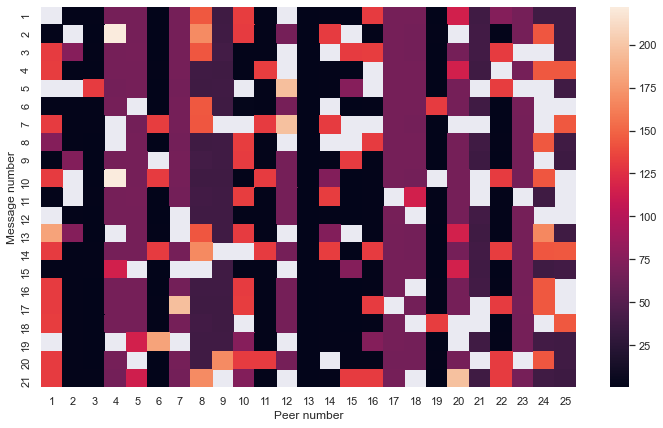

In [23]:
show_heat_map(df)

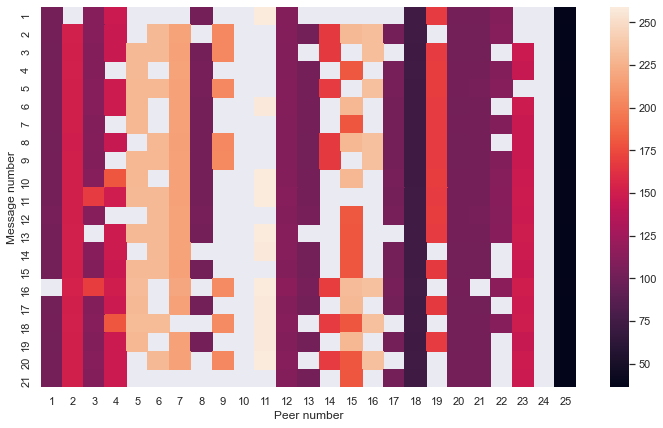

In [24]:
show_heat_map(em_df)

## Average time 

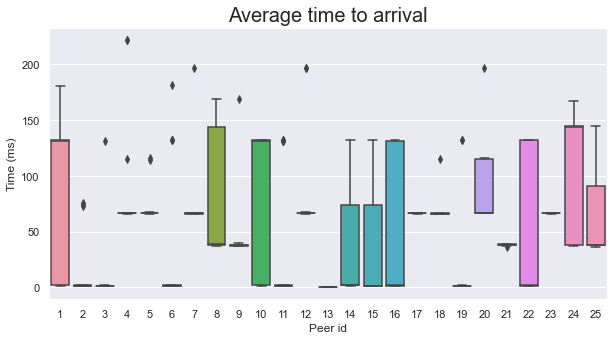

In [25]:
def show_avg_time(df):
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(data=df, )
    ax.set_title('Average time to arrival', fontsize= 20 )
    ax.set_ylabel('Time (ms)', fontsize=12)
    ax.set_xlabel('Peer id', fontsize=12)
    plt.show()
show_avg_time(df)

## Convergence speed

In [46]:
def conv(df):
    num_peers = len(df.columns)
    num_messages = len(df.index)
    
    
    a = df.values
    a.sort(axis=1)
    df2 = pd.DataFrame(a)
 

    df2.columns = ((i+1)/num_peers for i in df2.columns)
    df2.index = pd.RangeIndex(start=1, stop=num_messages+1, step=1)

    return df2.stack().reset_index().rename(columns={'level_0':'msg_num', 'level_1':'convergance', 0: 'time'})

def show_convergence(df):
    plt.figure(figsize=(10,6))
    sns.lineplot(x='time', y='convergance', data=conv(df), ci='sd', estimator="median", hue='msg_num')

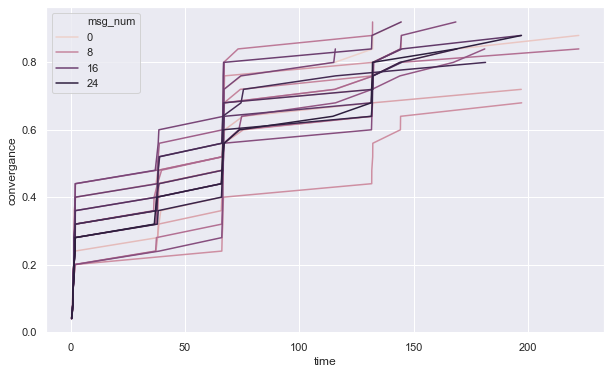

In [26]:
    
show_convergence(df)

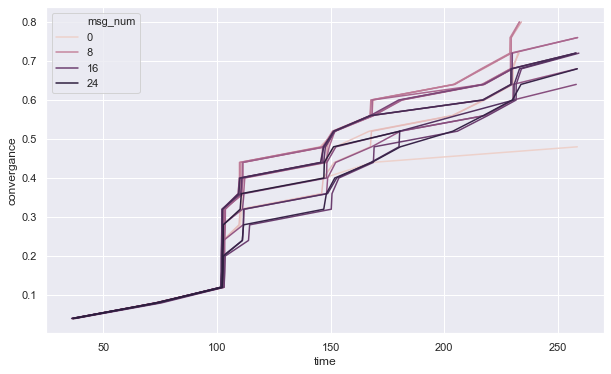

In [27]:
show_convergence(em_df)

## Overhead on peers 

Each gossip creates an overhead for peers. 


In [32]:
def calc_overhead(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].times_seen
    for k, times in store.items():
        msg_num, client_id = k.split('_')
        yield (int(msg_num), int(times))
    
def get_overhead_table(sim, storage_name):
    return pd.DataFrame({k: dict(calc_overhead(sim, k, storage_name)) 
                         for k in sim.types_peers['peer']}).sort_index()

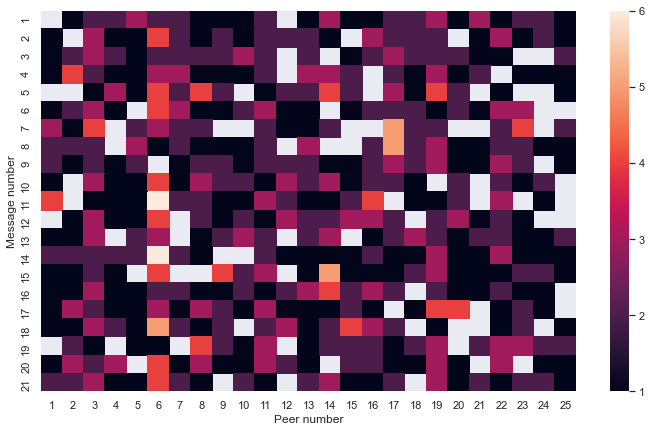

In [28]:
oh = get_overhead_table(net_sim, 'msg_time')
show_heat_map(oh)            

In [34]:
# Show average overhead on message
def show_overhead_hist(overhead_table):
    plt.figure(figsize=(10, 6))
    sns.distplot(overhead_table, norm_hist=True)
    plt.xlabel('Overhead (# times the message is seen by the same peer)', fontsize=15)

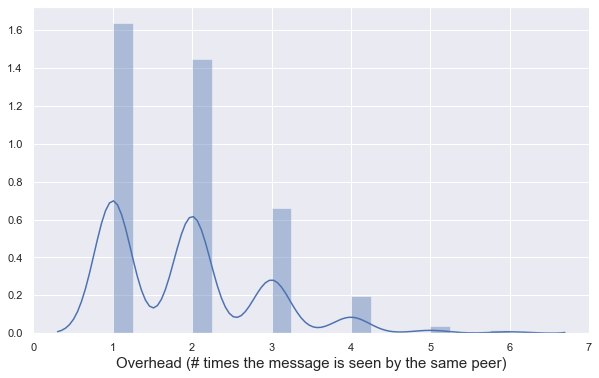

In [29]:
show_overhead_hist(oh)




# Achieving full convergence 


This is an exploratory section where you have one task: **full convergence**.

As it is clear from our gossip protocol, full convergence is not possible with this set of parameter configuration. What can we do to achieve it? 

Possible options: 

1. Tweak parameter of gossip protocol. Change `ttl` and `fanout`. But keep in mind that it will increase the load on the network. As our gossip protocol is blind, it might take a lot of resources to guarantee convergence. Also, `ttl` and `fanout` highly depend on the network topology. Try to change that and find out what the optimal `ttl` is as a function of the number of peers?     
2. Change the network topology. What is an optimal topology for convergence?  
3. Implement better gossip protocols. We were using a naive gossip, but there better variations based on [rumor-mongering and anti-entropy](http://www.cs.cornell.edu/courses/cs6410/2016fa/slides/19-p2p-gossip.pdf). A good start will be change gossip protocol to *pull-based* instead of *push-based*. 




Report for your gossip protocol: 
- If it achieves convergence. 
- Convergence speed.
- Average time to convergence.
- The overhead on peers. 


Report your findings: 
- How can you improve your gossip protocol further? 
- Try to change the topology? Can you still achieve convergence? 
- How big is the overhead on peers? How can you improve it? 



# 1. Tweak parameters

## Increase ttl with fixed fanout and simulation time

We start increasing ttl value by 1 and we run 10 simulations per ttl value. If all 10 simulations have converged at the end of the simulation, we consider this ttl value to be sufficient. Since there is a random element in the topology creation this value may change from execution to execution.

**Note** With increasing ttl, the simulation time increases, so the number of repetitions can be decreased to 5, with decreased certainty about the final ttl value.

In [30]:
ttl = 8
repetitions = 5

while True:
    converged = 0
    print("Trying TTL ", ttl)
    for i in range(repetitions):
        print("\tSimulation ", i+1)
        class GossipConfig(Config):
            exclude_types={'client',}
            fanout = 3
        
        class MessageProducerConfig(Config):
            init_ttl = ttl

        def prepare_peer_types():
            return { 'peer': PeerType(PeerConfig,   {BaseConnectionManager: None,
                                                    GossipService: GossipConfig }),
                 'client': PeerType(PeerConfig, {BaseConnectionManager: None,
                                                 MessageProducer: MessageProducerConfig })} 
        G = prepare_topology()
        net_sim = BaseSimulation(Locations, G, prepare_peer_types(),seed=i*ttl)
        net_sim.run(5_200)
        if get_gossip_table(net_sim, 'msg_time').isna().any().any():
            break
        else:
            converged+=1
    if converged == repetitions:
        print("Sufficient ttl value for random given topology, fanout 3, 25 peers, 1 client is:",ttl)
        break
    else:
        ttl+=1


Trying TTL  8
	Simulation  1
	Simulation  2
Trying TTL  9
	Simulation  1
	Simulation  2
	Simulation  3
	Simulation  4
Trying TTL  10
	Simulation  1
	Simulation  2
	Simulation  3
	Simulation  4
	Simulation  5
Sufficient ttl value for random given topology, fanout 3, 25 peers, 1 client is: 10


In [32]:
oh = get_overhead_table(net_sim, 'msg_time')

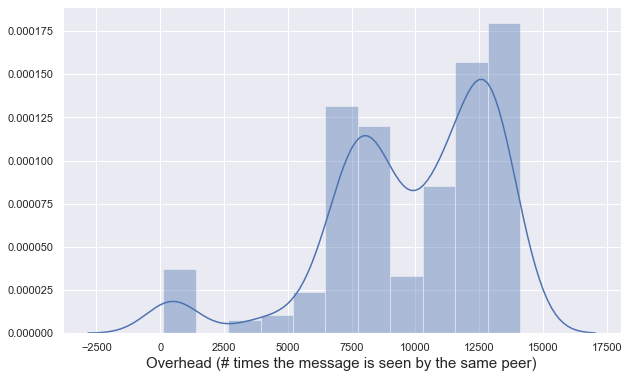

In [33]:
show_overhead_hist(oh)

We see that although the protocol converges with increased ttl, the overhead is extremely large.

## Increase fanout with fixed ttl and simulation time
We follow the same approach with above for the fanout value.

In [34]:
fanout = 3
repetitions = 10

while True:
    converged = 0
    print("Trying fanout ", fanout)
    for i in range(repetitions):
        print("Simulation ", i+1)
        class GossipConfig(Config):
            exclude_types={'client',}
            fanout = fanout
        
        class MessageProducerConfig(Config):
            init_ttl = 3

        def prepare_peer_types():
            return { 'peer': PeerType(PeerConfig,   {BaseConnectionManager: None,
                                                    GossipService: GossipConfig }),
                 'client': PeerType(PeerConfig, {BaseConnectionManager: None,
                                                 MessageProducer: MessageProducerConfig })} 
        G = prepare_topology()
        net_sim = BaseSimulation(Locations, G, prepare_peer_types())
        net_sim.run(5_200)
        if get_gossip_table(net_sim, 'msg_time').isna().any().any():
            break
        else:
            converged+=1
    if converged == repetitions:
        print("Sufficient fanout value for random given topology, ttl 3, 25 peers, 1 client is :",fanout)
        break
    else:
        fanout+=1


Trying fanout  3
Simulation  1
Trying fanout  4
Simulation  1
Trying fanout  5
Simulation  1
Trying fanout  6
Simulation  1
Simulation  2
Simulation  3
Simulation  4
Simulation  5
Simulation  6
Simulation  7
Simulation  8
Trying fanout  7
Simulation  1
Simulation  2
Simulation  3
Simulation  4
Simulation  5
Simulation  6
Simulation  7
Simulation  8
Simulation  9
Simulation  10
Sufficient fanout value for random given topology, ttl 3, 25 peers, 1 client is : 7


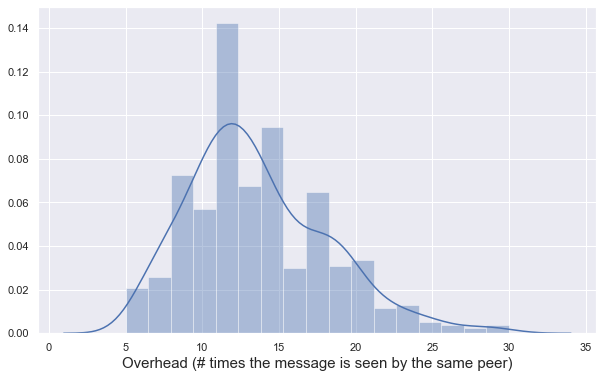

In [35]:
oh = get_overhead_table(net_sim, 'msg_time')

show_overhead_hist(oh)

We see that the approach with increased handout has a much smaller overhead, while the experiments are also much faster to execute.

## Check relation between number of peers and ttl with fixed fanout and simulation time
We start from 1 up to 25 peers and see at what value of ttl all the simulation repetitions converge.

In [16]:
# With a small number of nodes, sometimes nodes stay without connections, so we change the function to make sure
# that each node has at least one connection
import math
def prepare_fc_topology(num_peers=25, num_clients=1):    
    # Create network topology
    G = nx.erdos_renyi_graph(num_peers, 0.4)   
    nx.relabel_nodes(G, {k: k+1 for k in G.nodes()} ,copy=False)
    
    # Connect the client node to a random peer
    client_edges = [(i, choice(list(G.nodes()))) for i in range(num_peers+1, num_clients+num_peers+1)]
    G.add_edges_from(client_edges)
    
    ## Check if all nodes have at least one connection to another peer
    for n in G.nodes():
        if len(list(G.neighbors(n))) == 0:
            candidates = sample(list(range(1,num_peers+1)),math.ceil(0.4*num_peers)+1)
            G.add_edges_from([(n,c) for c in candidates])

    types_map = {k: 'peer' if k < num_peers+1 else 'client' for k in G.nodes()}
    # Assign a peer type to the peers 
    nx.set_node_attributes(G, types_map , 'type')
    return G

In [24]:
class GossipConfig(Config):
    exclude_types={'client',}
    fanout = 3
def prepare_peer_types():
    return { 'peer': PeerType(PeerConfig,   {BaseConnectionManager: None,
                                            GossipService: GossipConfig }),
         'client': PeerType(PeerConfig, {BaseConnectionManager: None,
                                         MessageProducer: MessageProducerConfig })}

peers_ttl = []
for num_peers in range(2,35):
    repetitions = 2
    print("Num peers:",num_peers)
    ttl = 1
    while True:
        print("\tTrying TTL",ttl)
        converged = 0
        class MessageProducerConfig(Config):
            init_ttl = ttl
        
        
        for i in range(repetitions):

            net_sim = BaseSimulation(Locations, prepare_fc_topology(num_peers=num_peers) , prepare_peer_types())
            net_sim.run(5_200)

            if get_gossip_table(net_sim, 'msg_time').isna().any().any():
                break
            else:
                converged+=1
        if converged == repetitions:
            peers_ttl.append(ttl)
            break
        else:
            ttl+=1
    

Num peers: 2
	Trying TTL 1
Num peers: 3
	Trying TTL 1
Num peers: 4
	Trying TTL 1
	Trying TTL 2
	Trying TTL 3
	Trying TTL 4
Num peers: 5
	Trying TTL 1
	Trying TTL 2
	Trying TTL 3
Num peers: 6
	Trying TTL 1
	Trying TTL 2
	Trying TTL 3
	Trying TTL 4
Num peers: 7
	Trying TTL 1
	Trying TTL 2
Num peers: 8
	Trying TTL 1
	Trying TTL 2
	Trying TTL 3
	Trying TTL 4
	Trying TTL 5
Num peers: 9
	Trying TTL 1
	Trying TTL 2
	Trying TTL 3
	Trying TTL 4
	Trying TTL 5
Num peers: 10
	Trying TTL 1
	Trying TTL 2
	Trying TTL 3
	Trying TTL 4
	Trying TTL 5
Num peers: 11
	Trying TTL 1
	Trying TTL 2
	Trying TTL 3
	Trying TTL 4
Num peers: 12
	Trying TTL 1
	Trying TTL 2
	Trying TTL 3
	Trying TTL 4
	Trying TTL 5
	Trying TTL 6
Num peers: 13
	Trying TTL 1
	Trying TTL 2
	Trying TTL 3
	Trying TTL 4
Num peers: 14
	Trying TTL 1
	Trying TTL 2
	Trying TTL 3
	Trying TTL 4
	Trying TTL 5
	Trying TTL 6
	Trying TTL 7
	Trying TTL 8
	Trying TTL 9
Num peers: 15
	Trying TTL 1
	Trying TTL 2
	Trying TTL 3
	Trying TTL 4
Num peers: 16


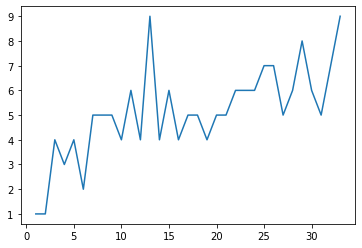

In [26]:
import numpy as np
import seaborn as sns
sns.lineplot(x=np.arange(1,len(peers_ttl)+1),y=peers_ttl)
plt.show()

We reduce the number of successful repetitions required to 2 in order to avoid large execution times.
We plot the relation between the number of peers and required ttl for convergence and we see that it roughly approaches a linear form.

# 2. Change topology
Intuitively, in a densely connected network, if we set the fanout to be large enough, we can achieve convergence quickly and at the same time avoid large ttl value or large overhead. Although this topology works for the simulation, a fully connected network is of course not achievable in real-world appications with millions of nodes. However, we can consider the possibility of clusters of nodes that can be fully connected, and some of those have the task to gossip messages to other clusters.
Another approach is to connect the client to more peers in order to better propagate the gossip messages in the cluster.

In [27]:
def prepare_optimal_topology(num_peers=25, num_clients=1):    
    # Create network topology
    G = nx.erdos_renyi_graph(num_peers, 0.4)   
    nx.relabel_nodes(G, {k: k+1 for k in G.nodes()} ,copy=False)
    
    # Connect the client node to a random peer
    #client_edges = [(i, choice(list(G.nodes()))) for i in range(num_peers+1, num_clients+num_peers+1)]
    #G.add_edges_from(client_edges)
    
    client_edges = [(i,j) for j in sample(list(G.nodes()),10) for i in range(num_peers+1, num_clients+num_peers+1)]
    G.add_edges_from(client_edges)

    types_map = {k: 'peer' if k < num_peers+1 else 'client' for k in G.nodes()}
    # Assign a peer type to the peers 
    nx.set_node_attributes(G, types_map , 'type')
    
    return G

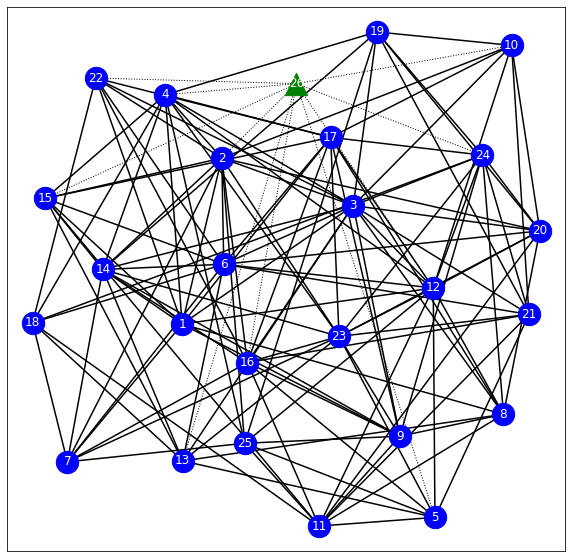

In [28]:
G = prepare_optimal_topology()
visualize_peer_client_network(G)

In [29]:
class GossipConfig(Config):
    exclude_types={'client',}
    fanout = 3

class MessageProducerConfig(Config):
    init_ttl = 3

def prepare_peer_types():
    return { 'peer': PeerType(PeerConfig,   {BaseConnectionManager: None,
                                            GossipService: GossipConfig }),
         'client': PeerType(PeerConfig, {BaseConnectionManager: None,
                                         MessageProducer: MessageProducerConfig })} 

net_sim = BaseSimulation(Locations, G, prepare_peer_types())
net_sim.run(5_200)

In [30]:
get_gossip_table(net_sim, 'msg_time').isna().any().any()

False

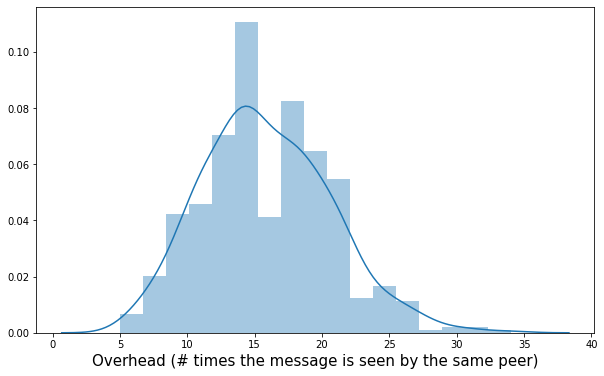

In [35]:
oh = get_overhead_table(net_sim, 'msg_time')
show_overhead_hist(oh)

## 3. Implement pull based gossip service

In [36]:
# Message gossip
from p2psimpy import *
from p2psimpy.services.base import BaseHandler
from p2psimpy.messages import BaseMessage
from p2psimpy.storage import Storage

from re import split 
from copy import copy

# Define a special message GossipMessage: Message with ttl
class GossipMessage(BaseMessage):

    __slots__ = ('sender', 'data')
    size = 1024
    
    def __init__(self, sender, data):
        super().__init__(sender, data)
        
class RequestUpdateMessage(BaseMessage):

    __slots__ = ('sender', 'data')
    
    def __init__(self, sender, index):
        super().__init__(sender, index)
        
class PullGossipService(BaseHandler, BaseRunner):

    def __init__(self, peer, init_timeout=200, fanout=20, request_update_interval=75, exclude_peers: set=None, exclude_types: set=None):
        super().__init__(peer)
        
        self.init_timeout = init_timeout
        self.fanout = fanout
        self.request_update_interval = request_update_interval
        self.counter = 1 
    
        if exclude_peers is None:
            self.exclude_peers = set() 
        else:
            self.exclude_peers = exclude_peers
        self.exclude_types = exclude_types
        
        self.strg_name = 'msg_time'
        self.peer.add_storage(self.strg_name, Storage())
        self.last_known_index = 0
        self.largest_received_index = 0

    def handle_message(self,msg):
        if isinstance(msg,GossipMessage):
            self.handle_gossip_message(msg)
        if isinstance(msg,RequestUpdateMessage):
            self.handle_request_update_message(msg)
            
    def handle_gossip_message(self, msg):
        # Store message localy 
        msg_id = msg.data
        idx = int(msg_id.split("_")[0])
        if idx>self.largest_received_index:
            self.largest_received_index = idx
        # Store the message id received with the current timestamp
        self.peer.store(self.strg_name, msg_id, self.peer.env.now)
    
    def handle_request_update_message(self, msg):
        request_index = msg.data

        if request_index < self.largest_received_index:
            receiver = msg.sender            
            for i in range(request_index+1,self.largest_received_index+1):
                msg_data = self.peer.storage[self.strg_name].get_all_by_prefix(str(i)+"_")
                if len(msg_data)>0:
                    self.peer.send(receiver, GossipMessage(self.peer, list(msg_data.keys())[0]))

    @property
    def messages(self):
        return GossipMessage,RequestUpdateMessage,

   
    def request_updates(self):
        for i in range(self.last_known_index+1,self.largest_received_index+2):
            msg_data = self.peer.storage[self.strg_name].get_all_by_prefix(str(i)+"_")
            if len(msg_data)==0:
                self.last_known_index = i - 1
                break
        self.peer.gossip( RequestUpdateMessage(self.peer, self.last_known_index), 
                             self.fanout, except_peers=self.exclude_peers, except_type=self.exclude_types)


    def run(self):
        # Wait the initial timeout
        yield self.env.timeout(self.init_timeout)
        while True:
            self.request_updates()
            yield self.env.timeout(self.request_update_interval)

In [37]:
from p2psimpy.services.base import BaseRunner

class MessageProducer(BaseRunner):

    def __init__(self, peer, init_timeout=1000, msg_rate=5, init_fanout=10):
        '''
        init_timeout: milliseconds to wait before starting the message production. 
        msg_rate: number of messages per second
        init_ttl: ttl to set up for the message 
        init_fanout: to how many peer send the message to
        '''
        super().__init__(peer)

        # calculate tx_interval
        self.init_timeout = init_timeout
        self.init_fanout = init_fanout
        
        self.tx_interval = 1000 / msg_rate
        self.counter = 1 
        
        # Let's add a storage layer to store messages
        self.strg_name = 'msg_time'
        self.peer.add_storage(self.strg_name, Storage())


    def produce_transaction(self):
        # Create a gossip message: message counter, peer_id and gossip it   
        self.peer.gossip(GossipMessage(self.peer,
                                       '_'.join((str(self.counter), str(self.peer.peer_id)))), 
                         self.init_fanout)
        # Locally store the message counter 
        self.peer.store(self.strg_name, str(self.counter), self.peer.env.now)
        self.counter+=1
        

    def run(self):
        # Wait the initial timeout
        yield self.env.timeout(self.init_timeout)
        while True:
            self.produce_transaction()
            yield self.env.timeout(self.tx_interval)

In [38]:
# Define locations 
from p2psimpy.config import *
from p2psimpy.consts import *
from p2psimpy.services.connection_manager import BaseConnectionManager
import networkx as nx
from random import choice, sample

import matplotlib.pyplot as plt

# We take the locations from AWS 
class Locations(Config):
    locations = ['Ohio', 'Ireland', 'Tokyo']
    latencies = {
        'Ohio': {'Ohio': Dist('invgamma', (5.54090, 0.333305, 0.987249)),
                 'Ireland': Dist('norm', (73.6995, 1.19583092197097127)),
                 'Tokyo': Dist('norm', (156.00904977375566, 0.09469886668079797))
                },
        'Ireland':{'Ireland': Dist('invgamma', (6.4360455224301525, 0.8312748033308526, 1.086191852963273)),
                   'Tokyo': Dist('norm', (131.0275, 0.25834811785650774))
                  },
        'Tokyo': {'Tokyo':  Dist('invgamma', (11.104508341331055, 0.3371934865734555, 2.0258998705983737))}
    }
    
# Define peer     
class PeerConfig(Config):
    location = Dist('sample', Locations.locations)
    bandwidth_ul = Dist( 'norm', (50*MBit, 10*MBit))
    bandwidth_dl = Dist( 'norm', (50*MBit, 10*MBit))

# Configuration used for our GossipService
class PullGossipConfig(Config):
    exclude_types={'client',}

# We have not two types of nodes: *peer* and *client*
def prepare_peer_types():
    return { 'peer': PeerType(PeerConfig,   {BaseConnectionManager: None,
                                                PullGossipService: PullGossipConfig }),
             'client': PeerType(PeerConfig, (BaseConnectionManager, MessageProducer))}

def prepare_topology(num_peers=25, num_clients=1):    
    # Create network topology
    G = nx.erdos_renyi_graph(num_peers, 0.6)   
    nx.relabel_nodes(G, {k: k+1 for k in G.nodes()} ,copy=False)
    
    # Connect the client node to many random peers
#     client_edges = [(i,j) for j in sample(list(G.nodes()),10) for i in range(num_peers+1, num_clients+num_peers+1)]
#     G.add_edges_from(client_edges)

    # Connect the client node to a random peer
    client_edges = [(i, choice(list(G.nodes()))) for i in range(num_peers+1, num_clients+num_peers+1)]
    G.add_edges_from(client_edges)
    
    ## Check if all nodes have at least one connection to another peer
    for n in G.nodes():
        if len(list(G.neighbors(n))) == 0:
            G.add_edges_from([(n,choice(list(range(1,num_peers+1))))])

    types_map = {k: 'peer' if k < num_peers+1 else 'client' for k in G.nodes()}
    # Assign a peer type to the peers 
    nx.set_node_attributes(G, types_map , 'type')
    return G

def visualize_peer_client_network(G):
    plt.figure(figsize=(10,10))

    # Draw client/ peer network 

    master_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'peer']
    client_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'client']

    pos = nx.kamada_kawai_layout(G)

    nx.draw_networkx_nodes(G, pos, nodelist=master_nodes, \
        node_color='blue', node_shape='o', node_size=500)
    nx.draw_networkx_nodes(G, pos, nodelist=client_nodes,  \
        node_color='green', node_shape='^', node_size=500, label=1)

    nx.draw_networkx_labels(G, pos, labels={k:k for k in master_nodes}, font_color='w')
    nx.draw_networkx_labels(G, pos, labels={k:k for k in client_nodes}, font_color='w')

    nx.draw_networkx_edges(G, pos, edgelist=G.subgraph(master_nodes).edges(), width=1.5)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(nbunch=client_nodes),  style='dotted')


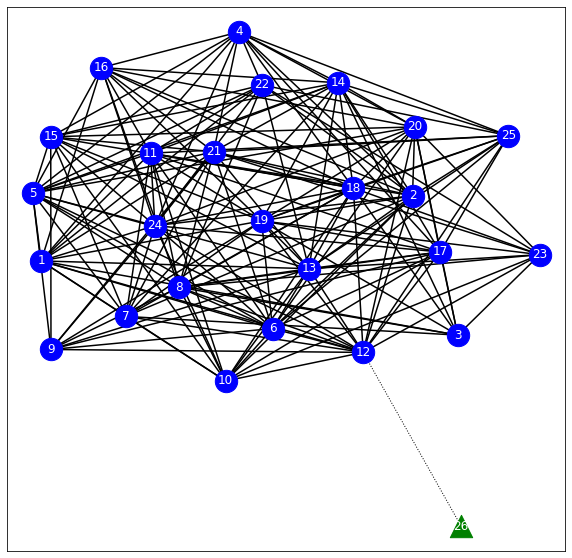

In [39]:
# Prepare and show target network topology 
G = prepare_topology()
visualize_peer_client_network(G)

In [40]:
from time import time
from p2psimpy.simulation import BaseSimulation

net_sim = BaseSimulation(Locations, G, prepare_peer_types(),enable_logger=True,logger_dir='logs3',seed=42)
net_sim.run(5_200)

In [41]:
import pandas as pd
pd.set_option('display.max_columns', 30)
df = get_gossip_table(net_sim, 'msg_time')
df


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
1,100.997094,156.126636,175.968543,100.559662,98.247580,101.023622,101.092957,101.205070,101.007110,98.778106,173.533902,36.827387,156.012941,175.485258,175.505669,173.172833,155.852792,156.262333,156.011003,156.283383,175.528672,175.501598,100.954830,98.563211,98.820365
2,51.004210,106.034957,125.934337,123.570256,122.896588,51.029161,50.992764,51.088610,51.014651,123.284757,125.958690,35.826322,105.881751,125.454790,125.508628,125.976253,105.907077,105.945363,106.081351,105.952477,125.534038,125.478056,51.003817,122.084813,123.539414
3,75.950444,130.991539,150.949058,147.903874,148.238262,76.129695,76.128737,75.991290,76.029598,74.726696,148.494716,37.616446,131.387103,150.495983,150.483743,148.492307,130.564086,131.147667,131.152482,131.083572,150.502238,150.546620,75.999761,75.480029,148.110855
4,101.046584,156.194369,175.977189,100.470450,98.678111,100.996153,100.977664,101.022604,101.016312,98.901950,172.902667,37.242309,156.139459,175.537991,175.481366,172.795153,155.966056,156.357915,155.860377,156.014266,175.489549,175.516215,100.968906,98.373360,97.814375
5,51.043640,106.079036,125.945212,122.834472,122.584299,50.976771,51.037240,51.080217,51.070821,122.092285,126.011484,37.848647,105.711702,125.520315,125.516991,125.971111,105.826995,106.114157,105.772984,106.101213,125.489782,125.482323,51.081205,122.030496,123.371948
6,75.997848,131.027259,150.966672,75.502641,75.464309,76.092572,76.052389,75.987399,76.012009,75.482188,146.791604,37.384438,130.758660,150.508127,150.495671,148.065275,131.073456,130.813404,130.907706,130.937141,150.513280,150.484228,76.017153,74.041528,147.649009
7,101.099529,156.124352,175.949806,100.481521,98.825425,101.043119,101.014008,100.965853,101.038231,98.733556,173.650217,36.320660,155.941747,175.477463,175.457322,173.746740,155.976209,156.187895,155.926848,155.828784,175.495602,175.523127,101.030133,98.391260,99.117595
8,51.026735,106.401323,126.018950,123.476901,122.694707,51.115551,51.073255,51.149102,50.996252,123.104917,125.929701,36.070764,106.444853,125.499818,125.491939,125.999309,106.082821,106.039811,105.952896,106.046464,125.506113,125.496883,51.045039,122.779321,124.318196
9,76.085888,131.027530,150.987533,75.471183,73.950604,76.004595,76.057529,76.104865,75.978566,73.894663,148.210441,35.657813,130.995407,150.476627,150.502129,147.260539,130.885942,131.033690,131.019854,130.991307,150.465554,150.507549,76.095629,74.538616,74.922864
10,101.057274,156.192899,175.928840,100.462260,99.333768,101.007147,100.995929,100.971480,101.009774,100.054428,173.028074,37.108693,155.967342,175.508719,175.462057,174.068784,156.062730,156.157109,155.926453,156.125261,175.512104,175.550110,101.079716,100.059464,97.919720


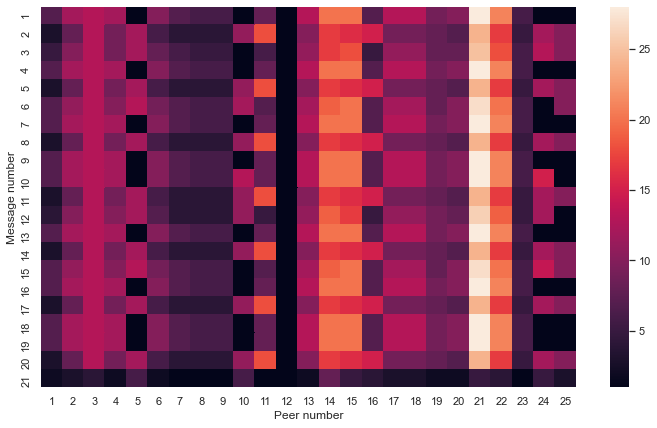

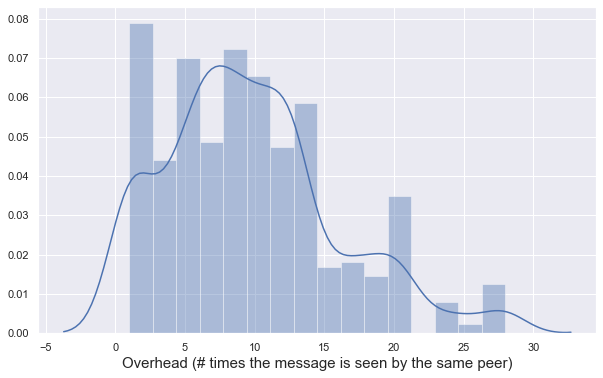

In [44]:
oh = get_overhead_table(net_sim, 'msg_time')
show_heat_map(oh)
show_overhead_hist(oh)

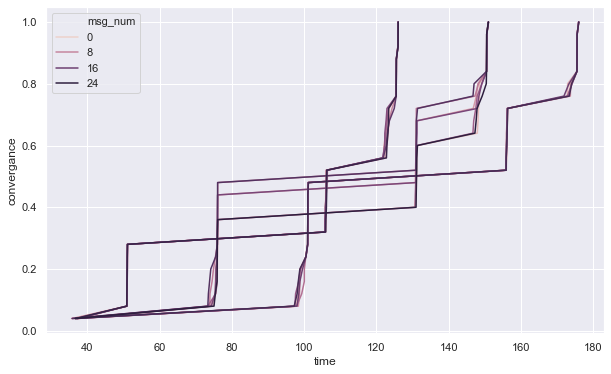

In [47]:
show_convergence(df)

In [48]:
# Final convergence speed
print(df.iloc[20].max() + 5000)
# Average convergence speed across rounds
df.max(axis=1).mean()

5150.990239509809


150.98338951080504

# Findings

- The pull-based gossip protocol consistently achieves convergence for the given simulation time. However, to achieve this without significantly lowering the request for updates frequency, we had to increase the edge possibility of the topology to 0.6 (which for 25 peers gives as an expected 15 connections per peer on average) and the fanout of the peers to 20 (so each peer asks all of its neighbors for updates).
- The average time to convergence for all messages seems to be around 150 ms.
- The overhead seems like a right-skewed normal distribution with a median around 10. It also has a characteristic peak on 1. 

# Improvements

An improvement that can be applied to the service is instead of asking for all the messages since the last confirmed known message, to check only for missing messages only and if there are any, ask those specifically, embedding the information in the RequestUpdate message. This will lead to more efficient information exchange, less requests for updates and significantly reduce the overhead on the peers. Another option is to have a push **and** pull service, so when a node receives a new message it immediately forwards it to its neigbors (based possibly again on a ttl value), pre-empting some of the requests for updates. 

Finally, for reproducibility you can save the experiment data. Use `.save_experiment(dir)` to save configurations for your experiment to a `dir` directory: locations, topology and peer services.  Whole experiment will be saved in yaml files. As they are saved in human readable format, you can always open and read the experiment configurations.

By default, it will not save the reference to implementations as it is not always [safe to do](https://github.com/yaml/pyyaml/wiki/PyYAML-yaml.load(input)-Deprecation). But if you are confident enough that other notebooks can find the service implementation feel free to use `include_module_classes=True`. 

For example, `GossipService` and `MessageProducer` cannot be saved as they are defined only within the scope of one notebook. If you want to include also implementations of services make sure to save them first somewhere where other notebooks can find it, e.g. to save into `py` file in `p2psimpy.services` module. 

In [ ]:
net_sim.save_experiment(expr_dir='gossip_expr')